In [18]:
!git config --global user.name "Erum-Hub"
!git config --global user.email "e_farooqi@gmail.com"

In [19]:
# Clone the GitHub repository
!git clone https://github.com/Erum-hub/LHL_LLM.git

# Change directory to the cloned repository
%cd LHL_LLM

Cloning into 'LHL_LLM'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 55 (delta 32), reused 4 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (55/55), 143.12 KiB | 1.01 MiB/s, done.
Resolving deltas: 100% (32/32), done.
/content/LHL_LLM/LHL_LLM/LHL_LLM/LHL_LLM/LHL_LLM


In [20]:
from google.colab import files
uploaded = files.upload()


Saving Customer_Reviews.csv to Customer_Reviews.csv


In [21]:
!mv Customer_Reviews.csv /content/LHL_LLM/

In [22]:
%cd /content/LHL_LLM
!git add Customer_Reviews.csv
!git commit -m "Add Customer_Reviews.csv"
!git push origin main  # or your branch name


/content/LHL_LLM
[main 1953e33] Add Customer_Reviews.csv
 1 file changed, 911 insertions(+)
 create mode 100644 Customer_Reviews.csv
fatal: could not read Username for 'https://github.com': No such device or address


In [23]:
import pandas as pd
import re

In [24]:
# Load dataset
df = pd.read_csv('/content/LHL_LLM/Customer_Reviews.csv')

In [5]:
# Inspect
print(df.head())

   Unnamed: 0                                          book name  \
0          17  Friends, Lovers, and the Big Terrible Thing: A...   
1         131                      Lessons in Chemistry: A Novel   
2         464                           Flash Cards: Sight Words   
3         644  A Court of Mist and Fury (A Court of Thorns an...   
4          78  The Ballad of Songbirds and Snakes (A Hunger G...   

                                        review title          reviewer  \
0                                    A very sad read  Veronica R Ewing   
1                    I LOVE THIS BOOK!! 😍 ⭐️⭐️⭐️⭐️⭐️             Sonia   
2                     Amazing for struggling readers     Ryan Williams   
3  The ending was stunning, as always, but I had ...          Brittany   
4                                         So Good!!!   Kindle Customer   

   reviewer rating                                 review description  \
0                4  What a shock to lose such a talented and funny...   


In [6]:
# Count unique values in the 'review title' column
unique_count = df['review title'].nunique()
print(f"Number of unique review titles: {unique_count}")

Number of unique review titles: 819


In [7]:
top_titles = df['review title'].value_counts().head(10)
print(top_titles)


review title
Great book     14
Cute book      10
Book            6
Cute            5
Love it         4
Great book!     4
Great           4
Perfect         3
Loved it!       3
Love            3
Name: count, dtype: int64


In [8]:
top_title_list = top_titles.index.tolist()
df['title_group'] = df['review title'].apply(lambda x: x if x in top_title_list else 'Other')


In [9]:
# Combine review title and description
df['text'] = df['review title'].fillna('') + '. ' + df['review description'].fillna('')

# Clean text
def clean_text(text):
    text = re.sub(r"[^a-zA-Z\s]", "", str(text))
    return text.lower().strip()

df['clean_text'] = df['text'].apply(clean_text)


In [10]:
import nltk
from nltk.corpus import stopwords

# Download stopwords if not already present
nltk.download('stopwords')

# Define stopword set
stop_words = set(stopwords.words('english'))

# Function to remove stopwords
def remove_stopwords(text):
    words = text.split()
    filtered = [word for word in words if word not in stop_words]
    return ' '.join(filtered)

# Apply to cleaned text
df['clean_text_nostop'] = df['clean_text'].apply(remove_stopwords)

# Rename the column
df = df.rename(columns={'clean_text_nostop': 'sentiment'})



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
# Keep only the last occurrence of 'sentiment'
df = df.loc[:, ~df.columns.duplicated(keep='last')]


In [12]:
# prompt: show headers

df.columns

Index(['Unnamed: 0', 'book name', 'review title', 'reviewer',
       'reviewer rating', 'review description', 'is_verified', 'date',
       'timestamp', 'ASIN', 'Author', 'title_group', 'text', 'clean_text',
       'sentiment'],
      dtype='object')

In [13]:
df[['sentiment', 'reviewer rating']].dropna().to_csv('cleaned_reviews.csv', index=False)


In [13]:
# Define labeling function
def classify_sentiment(text):
    text = text.lower()
    if any(word in text for word in ['excellent', 'great', 'love', 'amazing', 'perfect', 'recommend', 'good']):
        return 'recommended'
    elif any(word in text for word in ['bad', 'poor', 'terrible', 'worst', 'disappointed', 'not recommend']):
        return 'not recommended'
    else:
        return 'neutral'

# Apply function to sentiment column
df['label'] = df['sentiment'].apply(classify_sentiment)


In [15]:
# prompt: Using dataframe df: convert in csv

df.to_csv("df.csv")

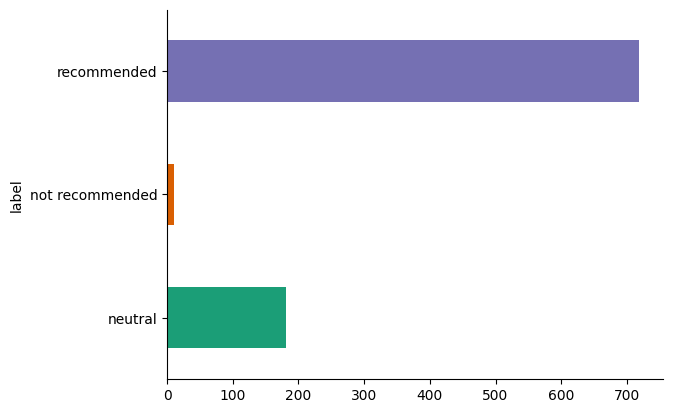

In [14]:
 #@title label

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Dataset has many more examples of recommended than others. Class imbalance problem.

/tmp/ipython-input-16-3740740557.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df, x='reviewer rating', y='label', inner='box', palette='Dark2')


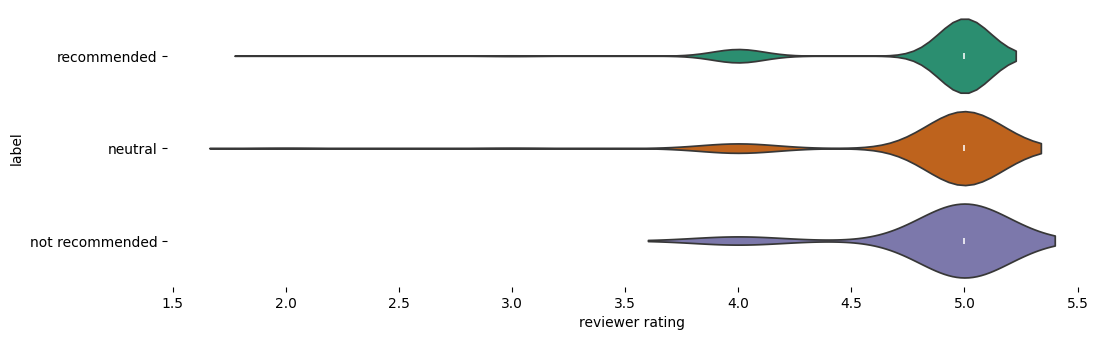

In [16]:
# @title label vs reviewer rating

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['label'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='reviewer rating', y='label', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

reviewer ratings (e.g., stars or numeric scores) does'nt  seem to align with the sentiment expressed in the review text.

In [17]:
# Assuming labels are already mapped as:
# 0 → recommended
# 1 → not recommended
# 2 → neutral
recommended = df[df['label'] == 'recommended']
not_recommended = df[df['label'] == 'not recommended']
neutral = df[df['label'] == 'neutral']

In [18]:
print("Class distribution:")
print(df['label'].value_counts())


Class distribution:
label
recommended        719
neutral            181
not recommended     10
Name: count, dtype: int64


In [19]:
from sklearn.utils import resample

# Find the majority class size
max_size = max(len(recommended), len(not_recommended), len(neutral))

# Upsample each class to match the majority size
recommended_upsampled = resample(recommended, replace=True, n_samples=max_size, random_state=42)
not_recommended_upsampled = resample(not_recommended, replace=True, n_samples=max_size, random_state=42)
neutral_upsampled = resample(neutral, replace=True, n_samples=max_size, random_state=42)

# Combine into a balanced dataset
df_balanced = pd.concat([recommended_upsampled, not_recommended_upsampled, neutral_upsampled])


In [20]:
from sklearn.utils import shuffle
df_balanced = shuffle(df_balanced, random_state=42).reset_index(drop=True)


In [19]:
# from sklearn.utils import resample

# # Separate classes
# majority = df[df['label'] == 'recommended']
# minority = df[df['label'] != 'recommended']

# # Downsample majority
# majority_downsampled = resample(majority,
#                                 replace=False,
#                                 n_samples=len(minority),
#                                 random_state=42)
# neutral_upsampled = resample(
#     neutral,
#     replace=True,
#     n_samples=len(recommended),
#     random_state=42
# )

# df_balanced = pd.concat([recommended, not_recommended_upsampled, neutral_upsampled])



NameError: name 'neutral' is not defined

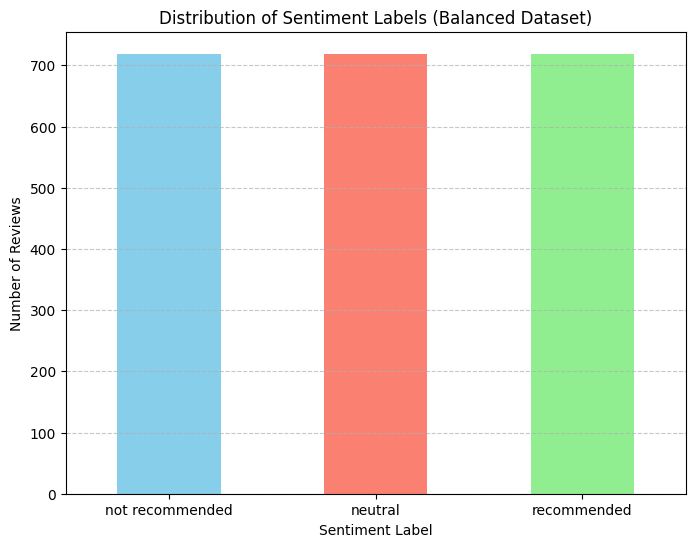

In [21]:
# prompt: suggest bar chart

sentiment_counts = df_balanced['label'].value_counts()

plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen'])
plt.title('Distribution of Sentiment Labels (Balanced Dataset)')
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [106]:
# # train test split
# from sklearn.model_selection import train_test_split

# X = df_balanced['sentiment']
# y = df_balanced['label']

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, stratify=y, random_state=42
)


Can delete this below

In [33]:
print(df['label'].value_counts())
print("Unique labels:", sorted(df['label'].unique()))


label
recommended        719
neutral            181
not recommended     10
Name: count, dtype: int64
Unique labels: ['neutral', 'not recommended', 'recommended']


In [23]:
label_map = {
    'recommended': 0,
    'not recommended': 1,
    'neutral': 2
}

df = df[df['label'].isin(label_map.keys())]  # Filter out any unexpected labels
df['label'] = df['label'].map(label_map)


2-Representation -Tokenization

In [24]:
import pandas as pd
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
import torch

# Load cleaned data
df = pd.read_csv('df.csv')

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df['sentiment'], df['label'], test_size=0.2, random_state=42)

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

train_encodings = tokenizer(list(X_train), truncation=True, padding=True, return_tensors="pt")
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, return_tensors="pt")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [26]:
import torch

# Load the saved data
train_encodings, train_labels = torch.load('train_data.pt', weights_only=False)
test_encodings, test_labels = torch.load('test_data.pt', weights_only=False)


# Inspect the keys and shapes
print("Train Encodings Keys:", train_encodings.keys())
print("Train Input IDs Shape:", train_encodings['input_ids'].shape)
print("Train Attention Mask Shape:", train_encodings['attention_mask'].shape)
print("Train Labels Shape:", train_labels.shape)

print("\nTest Input IDs Shape:", test_encodings['input_ids'].shape)
print("Test Labels Shape:", test_labels.shape)



Train Encodings Keys: KeysView({'input_ids': tensor([[  101,  2307,  2338,  ...,     0,     0,     0],
        [  101, 10140,  2338,  ...,     0,     0,     0],
        [  101,  2146,  1998,  ...,  1996, 11989,   102],
        ...,
        [  101,  2019, 20998,  ...,     0,     0,     0],
        [  101,  2093,  2808,  ...,  2734, 16294,   102],
        [  101,  2307,  2338,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]])})
Train Input IDs Shape: torch.Size([721, 512])
Train Attention Mask Shape: torch.Size([721, 512])
Train Labels Shape: 

3- Pretrained_Model

In [27]:
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForSequenceClassification
from torch.optim import AdamW

class ReviewDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.labels[idx]
        }
    def __len__(self):
        return len(self.labels)

train_dataset = ReviewDataset(train_encodings, train_labels)
test_dataset = ReviewDataset(test_encodings, test_labels)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4)

# Load model for 3 classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# import torch
# from torch.utils.data import Dataset, DataLoader
# from torch.optim import AdamW
# from transformers import AutoTokenizer, AutoModelForSequenceClassification
# from sklearn.metrics import classification_report
# from tqdm import tqdm

# # Set device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# # Load tokenizer and model
# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
# model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
# model.to(device)

# # Load preprocessed data
# train_encodings, train_labels = torch.load('train_data.pt', weights_only=False)
# test_encodings, test_labels = torch.load('test_data.pt', weights_only=False)

# # Dataset class
# class ReviewDataset(Dataset):
#     def __init__(self, encodings, labels):
#         self.encodings = encodings
#         self.labels = labels
#     def __getitem__(self, idx):
#         return {
#             'input_ids': self.encodings['input_ids'][idx],
#             'attention_mask': self.encodings['attention_mask'][idx],
#             'labels': self.labels[idx]
#         }
#     def __len__(self):
#         return len(self.labels)

# # Create datasets and loaders
# train_dataset = ReviewDataset(train_encodings, train_labels)
# test_dataset = ReviewDataset(test_encodings, test_labels)

# train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=8)

# # Optimizer
# optimizer = AdamW(model.parameters(), lr=5e-5)

# # Training loop
# epochs = 3
# for epoch in range(epochs):
#     model.train()
#     total_loss = 0
#     loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)

#     for batch in loop:
#         optimizer.zero_grad()
#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         labels = batch['labels'].to(device)

#         outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#         loss = outputs.loss
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()
#         loop.set_postfix(loss=loss.item())

#         del input_ids, attention_mask, labels, outputs
#         torch.cuda.empty_cache()

#     avg_loss = total_loss / len(train_loader)
#     print(f"✅ Epoch {epoch+1} completed — Average Loss: {avg_loss:.4f}")

# # Save the final model
# model.save_pretrained("sentiment_model")
# tokenizer.save_pretrained("sentiment_model")

# # Evaluation
# model.eval()
# predictions, true_labels = [], []

# with torch.no_grad():
#     for batch in test_loader:
#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         labels = batch['labels'].to(device)

#         outputs = model(input_ids, attention_mask=attention_mask)
#         preds = torch.argmax(outputs.logits, dim=1)

#         predictions.extend(preds.cpu().numpy())
#         true_labels.extend(labels.cpu().numpy())

# print("\n📊 Classification Report:")
# print(classification_report(true_labels, predictions, target_names=["recommended", "not recommended", "neutral"]))




Using device: cpu


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/3:   1%|          | 1/91 [01:19<1:58:58, 79.31s/it, loss=1.15]

In [28]:
from tqdm import tqdm

for epoch in range(3):
    total_loss = 0
    model.train()
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss=loss.item())

        del input_ids, attention_mask, labels, outputs
        torch.cuda.empty_cache()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} - Average Loss: {avg_loss:.4f}")


  0%|          | 0/181 [00:02<?, ?it/s]


KeyboardInterrupt: 

# 4. **Optimization**

In [29]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from sklearn.metrics import accuracy_score
from transformers import AutoModelForSequenceClassification


In [30]:

# Set random seed for reproducibility
torch.manual_seed(42)


In [31]:

# Load data (ensure weights_only=False for PyTorch 2.6+)
train_encodings, train_labels = torch.load('train_data.pt', weights_only=False)
test_encodings, test_labels = torch.load('test_data.pt', weights_only=False)


In [32]:
# Dataset class
class ReviewDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.labels[idx]
        }
    def __len__(self):
        return len(self.labels)



In [33]:
# Create datasets and loaders
train_dataset = ReviewDataset(train_encodings, train_labels)
test_dataset = ReviewDataset(test_encodings, test_labels)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)



In [34]:
# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim import AdamW
from sklearn.metrics import accuracy_score

# Load tokenized data (make sure you saved it with weights_only=False)
train_encodings, train_labels = torch.load('train_data.pt', weights_only=False)
test_encodings, test_labels = torch.load('test_data.pt', weights_only=False)

# Define custom dataset
class ReviewDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.labels[idx]
        }
    def __len__(self):
        return len(self.labels)

# Create dataset objects
train_dataset = ReviewDataset(train_encodings, train_labels)
test_dataset = ReviewDataset(test_encodings, test_labels)

# ✅ Reduce batch size to avoid memory issues
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4)

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
# Evaluation
model.eval()
preds, true_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=-1)
        preds.extend(predictions.cpu().numpy())
        true_labels.extend

## 5. ***deployment***

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Load trained weights if saved
# model.load_state_dict(torch.load("model.pt"))  # Optional

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
